In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

In [ ]:

#colab adjustment
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/MyDrive/Äkta_daten'
# assuming starting in run directory
#directory = os.getcwd()
dir_name = os.path.basename(directory)
print("Directory name:", dir_name)
os.chdir(directory)





Mounted at /content/drive
Directory name: Äkta_daten


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os

def plot(name, input_data, akta_type, **kwargs):
    """
    Plot chromatography data with flexible configuration options.

    Parameters:
    -----------
    name : str
        Output filename (without extension)
    input_data : pandas.DataFrame
        Input chromatography data (pre-processed by load function)
    akta_type : str, necessary due to difference in file format
        AKTA system type ('small' or 'large')

    Keyword Arguments:
    ------------------
    title : str, default=''
        Plot title
    fractions : list, default=[]
        List of fraction numbers to highlight
    fraction_text: float, default=0.7
        Height of fraction text marking fractions (0-1 scale)
    del_fraction_markings : list, default=[]
        Fractions to exclude from marking
    uv_color : str, default='#1f77b4'
        Color for UV absorption line
    conductivity_color : str, default='#d68924'
        Color for conductivity line
    buffer_color : str, default='#2ca02c'
        Color for buffer gradient line
    marker_color : str, default='#dc143c'
        Color for peak markers
    mark_maxima : bool, default=False
        Whether to mark peak maxima
    maxima_type : str, default='mL'
        Type of maxima annotation ('mL' or 'mAU')
    maxima_threshold : float, default=50
        Prominence threshold for peak detection
    max_width : int, default=10000
        Maximum width for peak detection
    salt : bool, default=False
        Whether to show conductivity data
    buffer : bool, default=False
        Whether to show buffer gradient
    output_datatype : str, default='jpeg'
        Output file format ('jpeg', 'svg', 'png', etc.)
    figsize : tuple, default=(12, 7)
        Figure size (width, height)
    x_lim : float, default=None
        Limit of the x axis (uses max volume if None)
    output_folder_path : str, default='/content/drive/MyDrive/Äkta_daten/Results'
        Path where output files will be saved
    """

    # Set default values
    defaults = {
        'title': '',
        'fractions': [],
        'fraction_text': 0.7,
        'del_fraction_markings': [],
        'uv_color': '#1f77b4',
        'conductivity_color': '#d68924',
        'buffer_color': '#db0404',
        'marker_color': '#2b2f99',
        'mark_maxima': False,
        'maxima_type': 'mL',
        'maxima_threshold': 50,
        'max_width': 10000,
        'salt': False,
        'buffer': False,
        'output_datatype': 'jpeg',
        'figsize': (12, 7),
        'x_lim': None,
        'output_folder_path': '/content/drive/MyDrive/Äkta_daten/Results'  # Single definition
    }

    # Validate keyword arguments
    valid_keys = set(defaults.keys())
    for key in kwargs.keys():
        if key not in valid_keys:
            print(f'Warning: you might have misspelled the variable: {key}. Which means the default parameter was used')

    # Update defaults with provided kwargs
    config = {**defaults, **kwargs}

    # The input_data is now expected to be pre-processed with correct column names and dtypes
    data = input_data.copy()

    # Create figure
    fig, ax1 = plt.subplots(figsize=config['figsize'])

    # Plot UV absorption
    uv_line, = ax1.plot(data['Volume_ml'], data['mAU'],
                        color=config['uv_color'], lw=5,
                        label='Absorbance at 280 nm')

    # Set labels and styling for primary axis (HARDCODED font sizes)
    ax1.set_xlabel('Retention volume [mL]', fontsize=17, fontweight='bold')
    ax1.set_ylabel(r"$\mathbf{A}_{\mathbf{280}}$" ' [mAU]', fontsize=17, fontweight='bold',
                   color=config['uv_color'])
    ax1.tick_params(axis='y', labelcolor=config['uv_color'], labelsize=16)  # Hardcoded
    ax1.tick_params(axis='x', labelsize=16)  # Hardcoded

    # Set axis limits
    x_lim = config['x_lim'] if config['x_lim'] is not None else data["Volume_ml"].max()
    y_lim = data["mAU"].max() + data["mAU"].max() * 0.2
    y_limmin = data["mAU"].iloc[100:].min()
    y_limmin = y_limmin - y_lim * 0.02
    ax1.set_xlim(0, x_lim)
    ax1.set_ylim(y_limmin, y_lim)

    # Mark maxima if requested
    if config['mark_maxima']:
        _add_maxima_markers(ax1, data, config)

    # Add fraction highlighting blue line
    if 'Fraction' in data.columns:
        _add_fraction_highlighting(ax1, data, config, akta_type)

    # Add fraction markers zahlen unten
    if 'Fraction' in data.columns:
        _add_fraction_markers(ax1, data, config, akta_type, y_limmin, y_lim, x_lim)

    # Set title
    ax1.set_title(config['title'], fontsize=20, fontweight='bold', pad=20)

    # Add secondary axes based on configuration
    lines = [uv_line]
    lines.extend(_add_secondary_axes(ax1, data, config))

    # Create legend
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left', frameon=True,
               framealpha=0.9, fontsize=16)

    # Finalize and save
    plt.tight_layout()

    # Use the single output_folder_path from config
    save_path = os.path.join(config["output_folder_path"], f'{name}.{config["output_datatype"]}')
    plt.savefig(save_path, format=config["output_datatype"])
    #plt.close()  # Added to prevent display issues
"""
Helper Functions
"""
def _add_maxima_markers(ax, data, config):
    """Add markers and annotations for peak maxima."""
    peaks = find_peaks(data.iloc[:, 1],
                      prominence=config['maxima_threshold'],
                      plateau_size=[0, 10],
                      width=[0, config['max_width']])
    for peak in peaks[0]:
        max_x = data['Volume_ml'][peak]
        max_y = data['mAU'][peak]
        ax.plot(max_x, max_y, 'o', color=config['marker_color'], markersize=6)

        # Add annotation based on type
        if config['maxima_type'] == 'mL':
            annotation_text = f'{max_x:.1f} mL'
        elif config['maxima_type'] == 'mAU':
            annotation_text = f'{max_y:.1f} mAU'
        else:
            annotation_text = f'{max_x:.1f} mL'  # fallback

        ax.annotate(annotation_text,
                   xy=(max_x, max_y),
                   xytext=(10, 10),
                   fontsize=15,
                   color=config['marker_color'],
                   textcoords='offset points',
                   ha='center')


def _add_fraction_highlighting(ax, data, config, akta_type):
    """Add transparent boxes for fraction highlighting."""
    for frac in config['fractions']:
        frac_number = str(frac)
        next_number = str(frac + 1)

        if akta_type == "small":
            vol_lower = data[data['Fraction'] == f"T{frac_number}"]['Fraction_vol']
            vol_higher = data[data['Fraction'] == f"T{next_number}"]['Fraction_vol']
        elif akta_type == "large":
            vol_lower = data[data['Fraction'] == frac_number]['Fraction_vol']
            vol_higher = data[data['Fraction'] == next_number]['Fraction_vol']

        if not vol_lower.empty and not vol_higher.empty:
            middle = (vol_lower.iloc[0] + vol_higher.iloc[0]) / 2
            ax.axvspan(vol_lower.iloc[0], vol_higher.iloc[0],
                      color='powderblue', alpha=0.3)
           # ax.text(middle, ax.get_ylim()[1] * config['fraction_text'], f'F{frac}', ha='center', va='center', fontsize=5.5, color='black')


def _add_fraction_markers(ax, data, config, akta_type, y_limmin, y_lim, x_lim):
    """Add vertical lines and labels for fraction markers."""
    y_pos = y_limmin + (y_lim - y_limmin) * 0.04

    del_fractions = []                              #converts desired fraction do string for filtering
    for frac in config['del_fraction_markings']:
        string = str(frac)
        if akta_type == 'small':    del_fractions.append(f'T{string}')
        elif akta_type == 'large':    del_fractions.append(f'{string}')

    for vol, frac in zip(data['Fraction_vol'], data['Fraction']):
        if pd.notna(vol) and pd.notna(frac) and frac not in del_fractions and frac not in ['Waste', 'Frac'] and vol < x_lim:
            ax.axvline(x=vol, color='gray', linestyle=':', alpha=0.5,
                      ymin=0, ymax=0.04)
            ax.text(vol, y_pos, str(frac).strip('""'),
                   rotation=90, va='bottom', ha='center', fontsize=9.5)



def _add_secondary_axes(ax1, data, config):
    """Add secondary axes for buffer and/or conductivity data."""
    additional_lines = []

    # Determine which secondary axes to add
    show_buffer = config['buffer']
    show_salt = config['salt']

    if show_buffer and not show_salt:
        # Only buffer
        ax2 = ax1.twinx()
        buffer_line, = ax2.plot(data['Volume_grad'], data['Gradient_percentB'],
                               color=config['buffer_color'], lw=4,
                               linestyle='--', label='Buffer B')
        ax2.set_ylabel('Buffer B [%]', fontsize=17, fontweight='bold',
                      color=config['buffer_color'])
        ax2.tick_params(axis='y', labelcolor=config['buffer_color'], labelsize=16)  # Hardcoded
        ax2.set_ylim(0, 105)
        additional_lines.append(buffer_line)

    elif show_salt and not show_buffer:
        # Only conductivity
        ax2 = ax1.twinx()
        conductivity_line, = ax2.plot(data['Volume_ml'], data['Cond'],
                                     color=config['conductivity_color'], lw=2,
                                     label='Conductivity')
        ax2.set_ylabel('Conductivity [mS/cm]', fontsize=17, fontweight='bold',
                      color=config['conductivity_color'])
        ax2.tick_params(axis='y', labelcolor=config['conductivity_color'], labelsize=16)  # Hardcoded
        y_lim_salt = data['Cond'].max() + data['Cond'].max() * 0.2
        ax2.set_ylim(0, y_lim_salt)
        additional_lines.append(conductivity_line)

    elif show_buffer and show_salt:
        # Both buffer and conductivity
        ax2 = ax1.twinx()
        buffer_line, = ax2.plot(data['Volume_grad'], data['Gradient_percentB'],
                               color=config['buffer_color'], lw=2,
                               linestyle='--', label='Buffer B')
        ax2.set_ylabel('Buffer B [%]', fontsize=17, fontweight='bold',
                      color=config['buffer_color'])
        ax2.tick_params(axis='y', labelcolor=config['buffer_color'], labelsize=16)  # Hardcoded
        ax2.set_ylim(0, 105)
        additional_lines.append(buffer_line)

        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        conductivity_line, = ax3.plot(data['Volume_ml'], data['Cond'],
                                     color=config['conductivity_color'], lw=2,
                                     label='Conductivity')
        ax3.set_ylabel('Conductivity [mS/cm]', fontsize=17, fontweight='bold',
                      color=config['conductivity_color'])
        ax3.tick_params(axis='y', labelcolor=config['conductivity_color'], labelsize=16)  # Hardcoded
        y_lim_salt = data['Cond'].max() + data['Cond'].max() * 0.2
        ax3.set_ylim(0, y_lim_salt)
        additional_lines.append(conductivity_line)

    return additional_lines


def load(name, akta_type, **kwargs):
    """
    Load chromatography data.

    Parameters:
    -----------
    name : str
        Input filename (without extension)
    akta_type : str, necessary due to difference in file format
        AKTA system type ('small' or 'large')

    Keyword Arguments:
    ------------------
    small_akta_filetype: str, default='csv'
        Type of file exported from the small akta('csv' or 'asc')
    """
    defaults = {'small_akta_filetype': 'csv'}
    config = {**defaults, **kwargs}

    # Determine separator and encoding
    if akta_type == 'small':
        if config['small_akta_filetype'] == 'csv':
            sep = ","
            encoding = 'utf_8'
        elif config['small_akta_filetype'] == 'asc':
            sep = "\t"
            encoding = 'utf_8'
        else:
            print("please enter 'csv' or 'asc' for small_akta_filetype")
            return None
    elif akta_type == 'large':
        sep = "\t"
        encoding = 'utf_16'
    else:
        print("please enter 'large' or 'small' for akta_type")
        return None

    file_path = f'{name}.{"csv" if akta_type == "large" or config["small_akta_filetype"] == "csv" else "asc"}'

    # Step 1: Read the header row (original file's second row, index 1) to find labels
    column_labels = []
    try:
        # Read the second line of the file (skip 1 row, read 1 row)
        header_df = pd.read_csv(file_path, sep=sep, encoding=encoding, skiprows=1, nrows=1, header=None)
        # Convert all elements to string and clean up potential whitespace/quotes
        column_labels = [str(x).strip().replace('"', '') for x in header_df.iloc[0].tolist()]
    except Exception as e:
        print(f"Warning: Could not read header row (original row 2) for dynamic column detection: {e}. Falling back to default column indices.")

    # Step 2: Determine actual data column indices based on user's rules
    # Default (hardcoded) indices for the actual data columns, assuming original file structure
    cond_data_col_idx = 3 # Original default for Cond
    volume_grad_data_col_idx = 4 # Original default for Volume_grad
    gradient_percentB_data_col_idx = 5 # Original default for Gradient_percentB

    # Try to find dynamic indices if header labels were read successfully
    if column_labels:
        for i, label in enumerate(column_labels):
            if "Conductivity" in label:
                cond_data_col_idx = i + 1 # User specified: 'Cond' is index + 1 from label
            if "ConcB" in label:
                volume_grad_data_col_idx = i # User specified: 'Volume_grad' is at 'ConcB' label index
                gradient_percentB_data_col_idx = i + 1 # User specified: 'Gradient_percentB' is at 'ConcB' label index + 1

    # Step 3: Load the main data
    # Actual data usually starts after the header rows and units, typically at original row 4 (index 3)
    raw_data = pd.read_csv(file_path, sep=sep, encoding=encoding, skiprows=3, header=None)

    # Ensure raw_data has enough columns for the determined indices, fallback if not
    max_col_idx_for_core_data = max(cond_data_col_idx, volume_grad_data_col_idx, gradient_percentB_data_col_idx, 1) # 1 for mAU (min expected column)
    if raw_data.shape[1] <= max_col_idx_for_core_data:
        print(f"Warning: Not enough columns in raw data after skipping rows for core data. Falling back to default column indices if dynamic ones out of bounds.")
        # Reset to hardcoded if dynamically found indices are out of bounds of the loaded raw_data
        cond_data_col_idx = 3
        volume_grad_data_col_idx = 4
        gradient_percentB_data_col_idx = 5

    # Detect Fraction columns from raw_data (which starts from original file's row 4, so index 0 here)
    fraction_col_idx_in_raw_data = None
    fraction_vol_col_idx_in_raw_data = None

    # Scan the first data row (raw_data.iloc[0]) for the value '2' to identify fraction columns.
    if not raw_data.empty:
        for col_idx in range(raw_data.shape[1]):
            # Check if the value can be interpreted as '2'
            try:
                if str(raw_data.iloc[0, col_idx]).strip() == '2':
                    fraction_col_idx_in_raw_data = col_idx
                    # Fraction volume is typically the column before the fraction number
                    fraction_vol_col_idx_in_raw_data = col_idx - 1 if col_idx > 0 else None
                    break
            except Exception:
                # Handle cases where conversion to string might fail for some reason
                pass

    # Step 4: Construct the final DataFrame using the identified column indices
    final_data_dict = {
        'Volume_ml': raw_data.iloc[:, 0], # Assuming first column is always Volume_ml
        'mAU': raw_data.iloc[:, 1],       # Assuming second column is always mAU
        'Volume_grad': raw_data.iloc[:, volume_grad_data_col_idx],
        'Gradient_percentB': raw_data.iloc[:, gradient_percentB_data_col_idx],
        'Cond': raw_data.iloc[:, cond_data_col_idx]
    }

    # Add fraction columns if detected
    if fraction_col_idx_in_raw_data is not None and fraction_vol_col_idx_in_raw_data is not None:
        # Check if the column indices are within the bounds of raw_data
        if fraction_vol_col_idx_in_raw_data < raw_data.shape[1] and fraction_col_idx_in_raw_data < raw_data.shape[1]:
            final_data_dict['Fraction_vol'] = raw_data.iloc[:, fraction_vol_col_idx_in_raw_data]
            final_data_dict['Fraction'] = raw_data.iloc[:, fraction_col_idx_in_raw_data]
        else:
            print(f"Warning: Detected fraction column indices ({fraction_vol_col_idx_in_raw_data}, {fraction_col_idx_in_raw_data}) are out of bounds for raw_data with {raw_data.shape[1]} columns. Fractions will not be loaded.")
            final_data_dict['Fraction_vol'] = None
            final_data_dict['Fraction'] = None
    else:
        final_data_dict['Fraction_vol'] = None
        final_data_dict['Fraction'] = None

    final_data = pd.DataFrame(final_data_dict)

    # Step 5: Convert all relevant columns to numeric, coercing errors
    # Add 'Fraction_vol' to the list of columns to convert to numeric
    cols_to_numeric = ['Volume_ml', 'mAU', 'Volume_grad', 'Gradient_percentB', 'Cond']
    if 'Fraction_vol' in final_data.columns:
        cols_to_numeric.append('Fraction_vol')

    for col in cols_to_numeric:
        final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

    # Convert 'Fraction' column to string type as it can contain mixed types (numbers, 'T1', etc.)
    if 'Fraction' in final_data.columns:
        final_data['Fraction'] = final_data['Fraction'].astype(str)

    return final_data


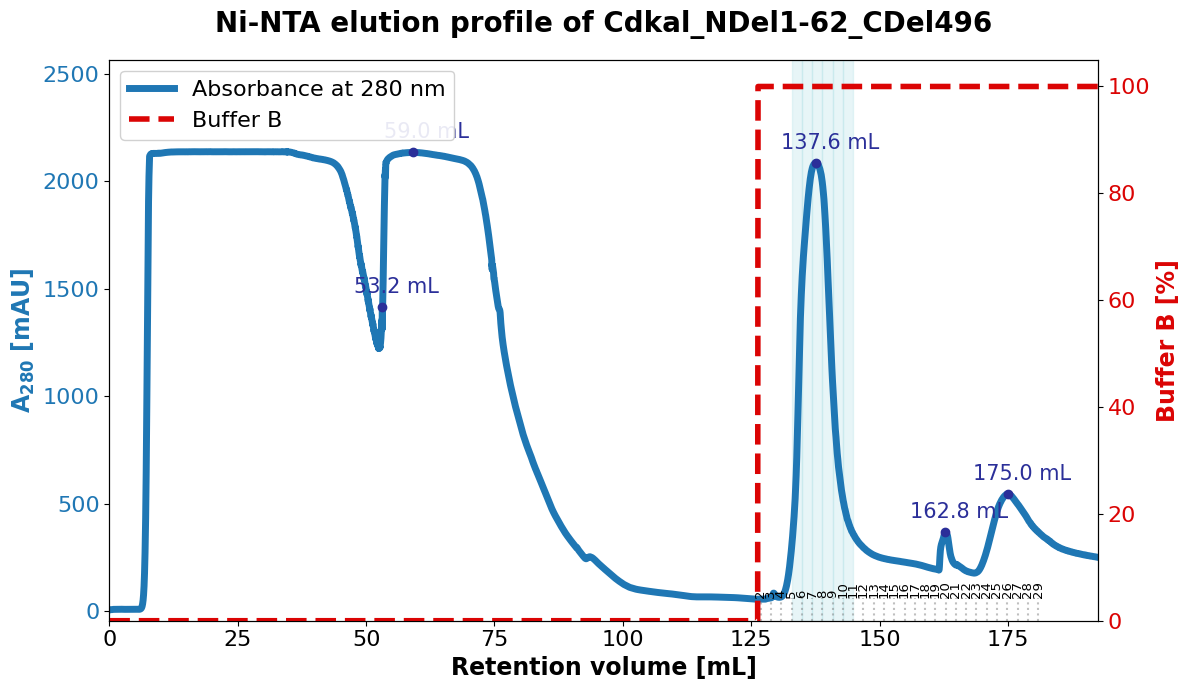

In [ ]:
# Usage example:
#titel sammlung: /content/drive/MyDrive/Äkta_daten/20251119_Cdkal_CDel1-62_NDel496_4L_LB_1NiNTA_GB.csv/content/drive/MyDrive/Äkta_daten/20251029_Cdkal_Ndel1-62_Cdel496_1NiNTA_4L_LB.csv
#Ni-NTA elution profile of Cdkal_NDel1-62_CDel496
#/content/drive/MyDrive/Äkta_daten/20251008_Cdkal_CDel1-62_NDel496_3L_LB_1NiNTA_GB.csv
name = '20251119_Cdkal_CDel1-62_NDel496_4L_LB_1NiNTA_GB'
akta_type = 'large'

data = load(name, akta_type=akta_type)  # Fixed: removed unnecessary 'filetype' parameter

if data is not None:
    plot(name, data, akta_type,
         title='Ni-NTA elution profile of Cdkal_NDel1-62_CDel496',
         buffer=True,
         salt=False,
         mark_maxima=True,
         maxima_type='mL',
         max_width=6000,
         fractions=[5,6,7,8,9,10],
         del_fraction_markings=[],
         fraction_text=0.95,
         #x_lim = 220,
         output_datatype='jpeg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')